In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

In [ ]:
# Loading data = Generar la data a través de Yahoo Finance
# Define the tickers for the S&P 500 and the bond index (e.g., 'SPY' for S&P 500 ETF, 'BND' for Vanguard Total Bond Market ETF)
equity_ticker = 'SPY'  # S&P 500 ETF
bond_ticker = 'BND'    # Total Bond Market ETF

# Define the date range
start_date = '2010-01-01'
end_date = '2023-09-30'

# Fetch the adjusted close prices
equity_data = yf.download(equity_ticker, start=start_date, end=end_date, interval='1mo')['Adj Close']
bond_data = yf.download(bond_ticker, start=start_date, end=end_date, interval='1mo')['Adj Close']

# Combine the data into a single DataFrame
df = pd.DataFrame({
    'S&P500': equity_data.pct_change().dropna(),
    'Bonds': bond_data.pct_change().dropna()
}).dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,S&P500,Bonds
Date,,
2010-02-01,0.031195,0.000127
2010-03-01,0.056528,-0.002042
2010-04-01,0.019652,0.010546
2010-05-01,-0.079455,0.011400
2010-06-01,-0.056231,0.014447
...,...,...
2023-05-01,0.004616,-0.011589
2023-06-01,0.060859,-0.002368
2023-07-01,0.036569,-0.001157


In [ ]:
# Definir todas las variables necesarias para una optimización MEAN-VARIANCE
# Calculate de logarithmic returns
df['log_S&P500'] = np.log(df['S&P500'] + 1)
df['log_Bonds'] = np.log(df['Bonds'] + 1)

# Compute mean and standard deviation of log returns
alpha_equities = df['log_S&P500'].mean()
alpha_bonds = df['log_Bonds'].mean()
sigma_equities = df['log_S&P500'].std()
sigma_bonds = df['log_Bonds'].std()

# Annualize the metrics
alpha_equities *= 12
alpha_bonds *= 12
sigma_equities *= np.sqrt(12)
sigma_bonds *= np.sqrt(12)

# Calculate correlation and covariance
corr = df[['log_S&P500', 'log_Bonds']].corr().iloc[0, 1]
cov = corr * sigma_equities * sigma_bonds

# Adjust expected returns
mu_equities = alpha_equities + (sigma_equities**2) / 2
mu_bonds = alpha_bonds + (sigma_bonds**2) / 2

In [ ]:
# Generar nuestros portafolios posibles de combinación BONOS-ACCIONES
weights = np.linspace(0, 1, 101)
p_mu = []
p_sigma = []
p_weights = []

for w_e in weights:
    w_b = 1 - w_e
    p_weights.append(w_e)
    returns = mu_equities * w_e + mu_bonds * w_b
    p_mu.append(returns)
    var = (w_e * sigma_equities)**2 + (w_b * sigma_bonds)**2 + 2 * w_e * w_b * cov
    sd = np.sqrt(var)
    p_sigma.append(sd)

# Create the portfolios DataFrame
portfolios = pd.DataFrame({
    'Returns': p_mu,
    'Volatility': p_sigma,
    'Peso Acciones': p_weights,
    'Peso Bonos': 1 - np.array(p_weights)
})

In [ ]:
portfolios

,Returns,Volatility,Peso Acciones,Peso Bonos
0,0.018998,0.043626,0.00,1.00
1,0.020119,0.043568,0.01,0.99
2,0.021240,0.043560,0.02,0.98
3,0.022360,0.043600,0.03,0.97
4,0.023481,0.043689,0.04,0.96
...,...,...,...,...
96,0.126577,0.144709,0.96,0.04
97,0.127697,0.146105,0.97,0.03
98,0.128818,0.147502,0.98,0.02
99,0.129939,0.148901,0.99,0.01


In [ ]:
# Step 1: Define the scoring system
# Ability to Take Risk Questions (Questions 1 to 3)
ability_questions = {
    1: {'a': 1, 'b': 3, 'c': 7, 'd': 10},
    2: {'a': 1, 'b': 3, 'c': 6, 'd': 8},
    3: {'a': 1, 'b': 2, 'c': 4, 'd': 6}
}

# Willingness to Take Risk Questions (Questions 4 to 6)
willingness_questions = {
    4: {'a': 1, 'b': 3, 'c': 5, 'd': 7},
    5: {'a': 1, 'b': 2, 'c': 4, 'd': 5},
    6: {'a': 1, 'b': 2, 'c': 3, 'd': 4}
}

# Step 2: Calculate total scores
def calculate_total_score(responses, ability_q, willingness_q):
    ability_score = 0
    willingness_score = 0

    # Calculate ability score
    for q in range(1, 4):
        answer = responses[q]
        ability_score += ability_q[q].get(answer, 0)

    # Calculate willingness score
    for q in range(4, 7):
        answer = responses[q]
        willingness_score += willingness_q[q].get(answer, 0)

    total_score = ability_score + willingness_score
    return ability_score, willingness_score, total_score

# Determine risk category
def get_risk_category(score):
    if 0 <= score <= 12:
        return 'Conservative'
    elif 13 <= score <= 20:
        return 'Moderately Conservative'
    elif 21 <= score <= 28:
        return 'Moderate'
    elif 29 <= score <= 34:
        return 'Moderately Aggressive'
    elif 35 <= score <= 40:
        return 'Aggressive'
    else:
        return 'Unknown'

In [ ]:
# Dictionary to store user's responses
user_responses = {}

# Function to validate user input
def get_response(question_number, options):
    while True:
        response = input("Seleccione una opción (a, b, c, d): ").lower()
        if response in options:
            return response
        else:
            print("Entrada inválida. Por favor, ingrese 'a', 'b', 'c' o 'd'.")

# Present the questions and collect user responses
print("Cuestionario de Tolerancia al Riesgo\n")

# Question 1
print("1. Mi edad actual es:")
print("a. Más de 60 años")
print("b. 50 a 60 años")
print("c. 35 a 59 años")
print("d. 34 años o menos")
user_responses[1] = get_response(1, ['a', 'b', 'c', 'd'])

# Question 2
print("\n2. Planeo retirar dinero de mi cuenta de plan de retiro en:")
print("a. Menos de 5 años")
print("b. De 5 a 9 años")
print("c. De 10 a 15 años")
print("d. Más de 15 años")
user_responses[2] = get_response(2, ['a', 'b', 'c', 'd'])

# Question 3
print("\n3. Debería tener suficientes ahorros e ingresos estables/garantizados (plan de retiro, ahorros, inversiones) para mantener mi estándar de vida planificado en la jubilación:")
print("a. No estoy seguro")
print("b. Algo seguro")
print("c. Seguro")
print("d. Muy seguro")
user_responses[3] = get_response(3, ['a', 'b', 'c', 'd'])

# Question 4
print("\n4. La siguiente afirmación describe mejor mi disposición para asumir riesgo:")
print("a. Me preocupa más evitar pérdidas en el valor de mi cuenta que experimentar crecimiento.")
print("b. Deseo crecimiento en el valor de mi cuenta, pero me preocupa más evitar pérdidas.")
print("c. Me preocupa evitar pérdidas, pero esto se ve superado por mi deseo de lograr crecimiento.")
print("d. Para maximizar la posibilidad de experimentar alto crecimiento, estoy dispuesto a aceptar pérdidas.")
user_responses[4] = get_response(4, ['a', 'b', 'c', 'd'])

# Question 5
print("\n5. Si invierto $100,000 y el valor de mi cartera disminuye a $70,000 en solo unos meses, yo:")
print("a. Estaría muy preocupado y vendería mis inversiones.")
print("b. Estaría algo preocupado y consideraría asignar a inversiones de menor riesgo.")
print("c. No me preocuparía por las fluctuaciones temporales en mis rendimientos.")
print("d. Invertiría más en mi cartera actual.")
user_responses[5] = get_response(5, ['a', 'b', 'c', 'd'])

# Question 6
print("\n6. Mis activos (excluyendo casa y automóvil) están invertidos en:")
print("a. No tengo activos invertidos.")
print("b. Mi pensión, certificados de depósito (CDs), anualidades, cuentas IRA y cuentas de ahorro.")
print("c. Una mezcla de acciones y bonos, incluyendo fondos mutuos.")
print("d. Acciones o fondos mutuos de acciones.")
user_responses[6] = get_response(6, ['a', 'b', 'c', 'd'])

Cuestionario de Tolerancia al Riesgo

1. Mi edad actual es:
a. Más de 60 años
b. 50 a 60 años
c. 35 a 59 años
d. 34 años o menos
Seleccione una opción (a, b, c, d): d

2. Planeo retirar dinero de mi cuenta de plan de retiro en:
a. Menos de 5 años
b. De 5 a 9 años
c. De 10 a 15 años
d. Más de 15 años
Seleccione una opción (a, b, c, d): d

3. Debería tener suficientes ahorros e ingresos estables/garantizados (plan de retiro, ahorros, inversiones) para mantener mi estándar de vida planificado en la jubilación:
a. No estoy seguro
b. Algo seguro
c. Seguro
d. Muy seguro
Seleccione una opción (a, b, c, d): c

4. La siguiente afirmación describe mejor mi disposición para asumir riesgo:
a. Me preocupa más evitar pérdidas en el valor de mi cuenta que experimentar crecimiento.
b. Deseo crecimiento en el valor de mi cuenta, pero me preocupa más evitar pérdidas.
c. Me preocupa evitar pérdidas, pero esto se ve superado por mi deseo de lograr crecimiento.
d. Para maximizar la posibilidad de experimen

In [ ]:
# Poner en marcha nuestro sistema de punteo
# Calculate the scores
ability_score, willingness_score, total_score = calculate_total_score(
    user_responses, ability_questions, willingness_questions)

risk_category = get_risk_category(total_score)

print(f"Risk Category: {risk_category}")
print(f"Ability Score: {ability_score}")
print(f"Willingness Score: {willingness_score}")
print(f"Total Risk Score: {total_score}")

Risk Category: Moderately Aggressive
Ability Score: 22
Willingness Score: 8
Total Risk Score: 30


In [ ]:
# Definir nuestra función que va a hacer el MAPA del cuestionario a un criterio de "aversión al riesgo", utilizando una función sigmoide
# Step 4: Map total score to Lambda using linear mapping
def map_score_to_lambda_linear(score, lambda_min=0.5, lambda_max=10, score_min=0, score_max=40):
    lambda_value = lambda_max - ((score - score_min) / (score_max - score_min)) * (lambda_max - lambda_min)
    return lambda_value

Lambda = map_score_to_lambda_linear(total_score)
print(f"User's Risk Aversion (Lambda): {Lambda:.2f}")

User's Risk Aversion (Lambda): 2.88


In [ ]:
# Encontrar el portfolio que maximiza los retornos ajustados por riesgo del usuario
# Calculate Risk Adjusted Returns
portfolios['Risk Adj. Return'] = portfolios['Returns'] - Lambda * (portfolios['Volatility']**2)

# Find the optimal portfolio
max_return = portfolios['Risk Adj. Return'].max()
max_portfolio = portfolios.loc[portfolios['Risk Adj. Return'] == max_return].iloc[0]

# Extract optimal weights and portfolio characteristics
w_equities = max_portfolio['Peso Acciones']
w_bonds = max_portfolio['Peso Bonos']
mu_w = max_portfolio['Returns']
sigma_w = max_portfolio['Volatility']
alpha_w = mu_w - (sigma_w**2) / 2

# Calcular la probabilidad de perdida y el VaR del portfolio
# Calculate the probability of negative returns
prob_negative = norm.cdf(0, loc=alpha_w, scale=sigma_w)

# Calculate Value-at-Risk (VaR)
var_5 = norm.ppf(0.05, loc=alpha_w, scale=sigma_w)
var_1 = norm.ppf(0.01, loc=alpha_w, scale=sigma_w)

# Organize outputs
data = {
    'Characteristics': ['Equities Weight', 'Bonds Weight', 'Expected Return (μW)', 'Volatility (σW)',
                        'Probability of Loss', 'VaR at 5%', 'VaR at 1%'],
    'Values': [
        f"{w_equities * 100:.2f}%", f"{w_bonds * 100:.2f}%", f"{mu_w * 100:.2f}%", f"{sigma_w * 100:.2f}%",
        f"{prob_negative * 100:.2f}%", f"{var_5 * 100:.2f}%", f"{var_1 * 100:.2f}%"
    ]
}
results_df = pd.DataFrame(data)
print("\nOptimal Portfolio Characteristics:")
print(results_df)


Optimal Portfolio Characteristics:
        Characteristics   Values
0       Equities Weight   93.00%
1          Bonds Weight    7.00%
2  Expected Return (μW)   12.32%
3       Volatility (σW)   14.05%
4   Probability of Loss   21.00%
5             VaR at 5%  -11.78%
6             VaR at 1%  -21.36%


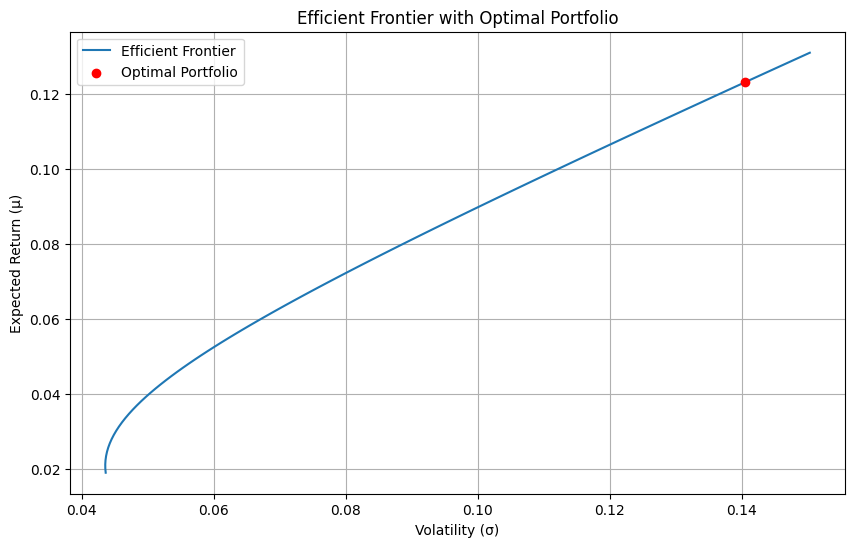

In [ ]:
# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(portfolios['Volatility'], portfolios['Returns'], label='Efficient Frontier')
plt.scatter(max_portfolio['Volatility'], max_portfolio['Returns'], color='red', label='Optimal Portfolio', zorder=5)
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.legend()
plt.grid(True)
plt.show()

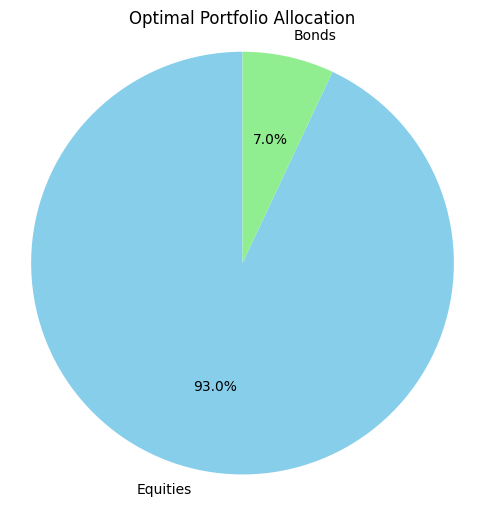

In [ ]:
# Plot the optimal portfolio allocation
labels = ['Equities', 'Bonds']
sizes = [w_equities, w_bonds]
colors = ['skyblue', 'lightgreen']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
